# imports

In [12]:
# load and autoreload
from IPython import get_ipython

# this automatically updates changes in other file's funcionts.
# it is very handy for data exploration
try:
    _magic = get_ipython().run_line_magic
    _magic("load_ext", "autoreload")
    _magic("autoreload", "2")
except:
    pass


import datetime as dt
import glob

# import most used packages
import os
import pprint
import sys

import cartopy as crt
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import bnn_tools

In [14]:
# import customs functions

import bnn_tools.basic_funs as bfu
import bnn_tools.bnn_array
import bnn_tools.coag_sink as cs
import bnn_tools.funs as fu

## mean free path

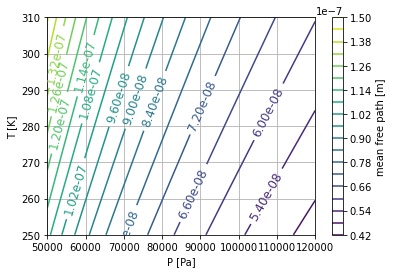

In [15]:
def plt_mean_free_path():
    T_ = xr.DataArray(np.linspace(250, 310, 100), dims="T", attrs={"units": "K"})
    P_ = xr.DataArray(
        np.linspace(50_000, 120_000, 100), dims="P", attrs={"units": "Pa"}
    )

    Tb, Pb = xr.broadcast(T_.assign_coords({"T": T_}), P_.assign_coords({"P": P_}))
    mfp = cs.calc_MFP(T=Tb, P=Pb)
    mfp.name = "mean free path"

    mfp.bnn.u("m")
    #     global res
    #     global ax
    res = mfp.plot.contour(levels=20, add_colorbar=True)
    ax = plt.gca()
    ax.clabel(res, inline=1, fmt="%1.2e", fontsize=12)  # label every second level
    ax.grid(which="both")


plt_mean_free_path()

## viscocity 

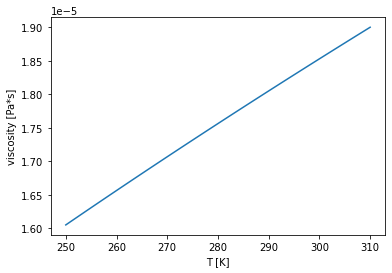

In [16]:
def _plot_vis():
    T_ = xr.DataArray(np.linspace(250, 310, 100), dims="T", attrs={"units": "K"})
    T_ = T_.assign_coords({"T": T_})

    _vis = cs.calc_viscosity(T_)
    _vis.name = "viscosity"
    _vis.bnn.u("Pa*s")

    _vis.plot()


_plot_vis()

## calc_coag_coef_fuchs

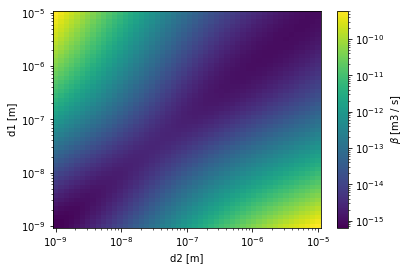

In [17]:
def _plt_coag_coef():
    d1_ = xr.DataArray(np.geomspace(1e-9, 1e-5), dims="d1", attrs={"units": "m"})
    d2_ = xr.DataArray(np.geomspace(1e-9, 1e-5), dims="d2", attrs={"units": "m"})
    d1, d2 = xr.broadcast(
        d1_.assign_coords({"d1": d1_}), d2_.assign_coords({"d2": d2_})
    )
    alpha = 1
    
    # is this correct? 
    dens1 = dens2 = 1_000
    
    T = 300
    P = 101_000
    ccf = cs.calc_coag_coef_fuchs(d1, dens1, d2, dens2, T, P, alpha)
    ccf.name = r"$\beta$"
    ccf.bnn.u("m3 / s")
    ccf.plot(norm=mpl.colors.LogNorm(), yscale="log", xscale="log")
    return ccf


ccf = _plt_coag_coef()

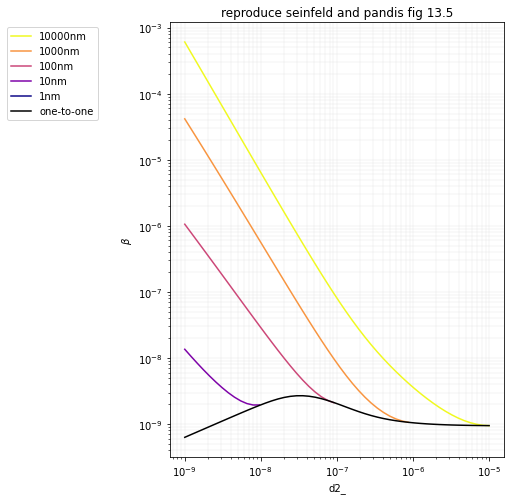

In [18]:
def _plt_pandis(ccf):
    cm = ccf * 1e6
    d2_ = xr.DataArray(
        np.geomspace(1e-9, 1e-5), dims="d2_", coords={"d2_": np.geomspace(1e-9, 1e-5)}
    )
    d1_ = xr.DataArray(
        np.geomspace(1e-9, 1e-5), dims="d2_", coords={"d2_": np.geomspace(1e-9, 1e-5)}
    )
    cm_ = cm.interp({"d2": d2_, "d1": d1_}).reset_coords(drop=True)
    cmap = plt.get_cmap("plasma")

    for i in (np.array([1, 10, 100, 1_000, 10_000]) / 1e9)[::-1]:
        cm.interp({"d1": i}).where(cm["d2"] <= i).plot(
            yscale="log",
            xscale="log",
            label=f"{i * 1e9:1.0f}nm",
            color=cmap(
                (np.log10(i) - np.log10(1e-9)) / np.log10(10_000),
            ),
        )

    cm_.plot(c="k", label="one-to-one", zorder=100)
    ax = plt.gca()
    ax.legend(loc=1, bbox_to_anchor=(-0.2, 1))
    ax.grid(which="both", lw=0.2, c=".8")
    ax.set_title("reproduce seinfeld and pandis fig 13.5")
    f = plt.gcf()
    f.set_figheight(8)


_plt_pandis(ccf)

- it seems quite good 
    - however for 10 um we are overestimated—doubling

# open sum nais file 

In [19]:
_p = os.path.dirname(os.path.dirname(bnn_tools.__path__[0]))

_p

'/Users/aliaga/Documents/Work_DA/Py-packs/bnn-tools-repo'

In [20]:
p = os.path.join(_p, "example_data/NAISn20220515np.sum")
# dataset (xarray) of the sum data.
ds = fu.open_sum2ds(p)

In [21]:
pp = os.path.join(_p, "example_data/izanapsm2022_inv_kernel_20220515.dat")

In [22]:
ds_psm = fu.open_psm2ds(pp)

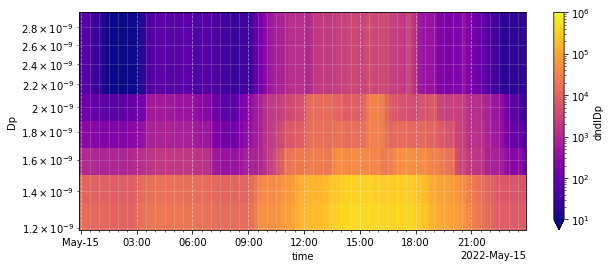

In [23]:
ds_psm.bnn.plot_psd()

# open smsp 

In [24]:
p3 = os.path.join(_p, "example_data/202205101400_SMPS.txt")

In [25]:
ds_s = fu.open_smps2ds(p3).loc[{"time": "2022-05-15"}]

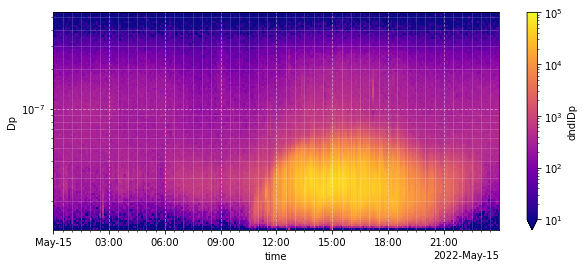

In [26]:
ds_s.bnn.plot_psd(vmax=1e5)

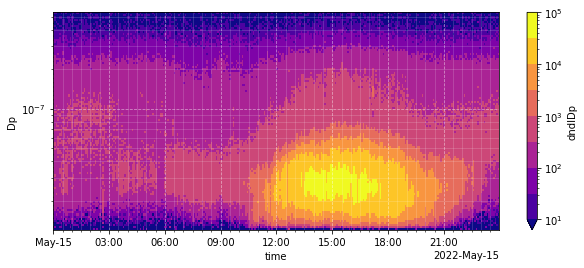

In [27]:
ds_s.bnn.plot_psd(vmax=1e5, levels=9)

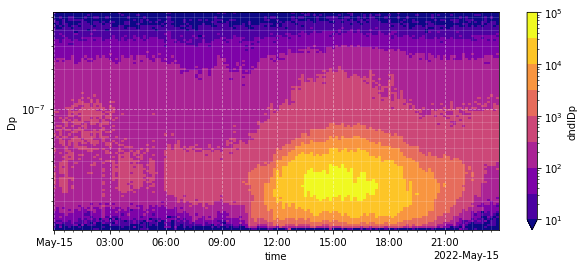

In [28]:
ds_s.resample({"time": "10.01T"}).median().bnn.plot_psd(vmax=1e5, levels=9)

In [31]:
_ds_s = ds_s.bnn.set_lDp()
for i in range(5):
    _ds_s = _ds_s.rolling({"time": 3}, center=True, min_periods=1).mean()
    _ds_s = _ds_s.rolling({"lDp": 3}, center=True, min_periods=1).mean()

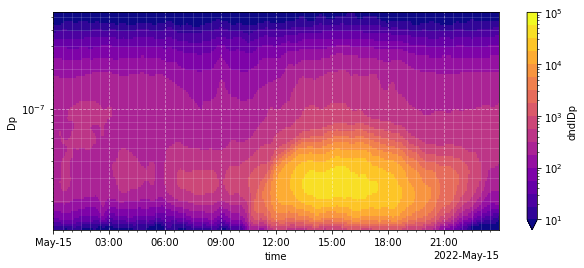

In [32]:
_ds_s.bnn.plot_psd(vmax=1e5, levels=17)

# combine two along DP

In [33]:
N, _, _ = ds_s.bnn.get_N(d1=10e-9, d2=1)

In [34]:
N1 = ds_s["dndlDp"].bnn.get_exact_N(15e-9, 500e-9)

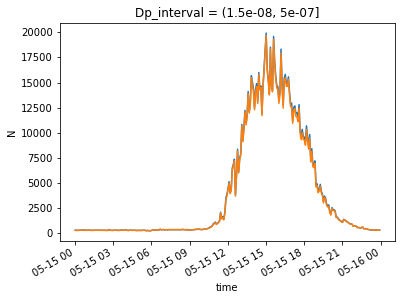

In [35]:
N.plot()
N1.plot()

In [36]:
ts = 300
dpr = 0.05
Dp_cut = 3e-9
Dp_cut1 = 20e-9


dsn1 = ds.bnn.resample_ts(ts)[["dndlDp"]]

dsn2 = dsn1.bnn.dp_regrid(10, dpr)

dsp1 = ds_psm.bnn.upsample_ts(ts).bnn.set_Dp()

dsp2 = dsp1.bnn.dp_regrid(10, dpr)


dss1 = ds_s.bnn.upsample_ts(ts)[["dndlDp"]]


dss2 = dss1.bnn.dp_regrid(10, dpr)

In [37]:
dc = fu.combine_2_spectras(dsp2, dsn2, cut_dim="lDp", cut_point=np.log10(Dp_cut))

dc1 = fu.combine_2_spectras(dc, dss2, cut_dim="lDp", cut_point=np.log10(Dp_cut1))

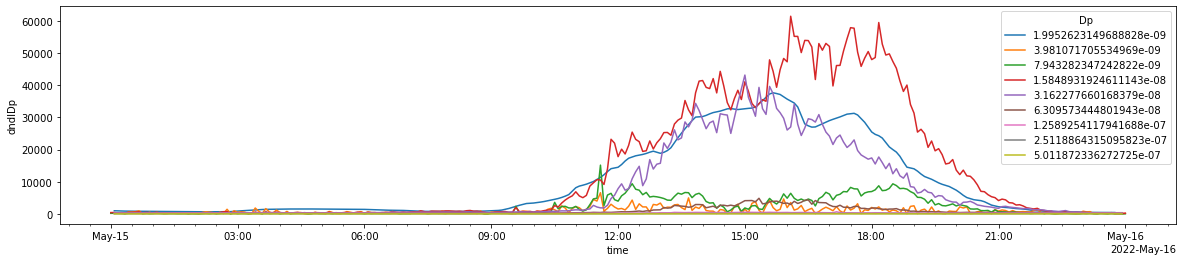

In [40]:
dc1.bnn.set_time().bnn.dp_regrid(10, 0.3).bnn.set_Dp().plot(hue="Dp")
f = plt.gcf()
f.set_figwidth(20)
ax = plt.gca()
bfu.format_ticks(ax)

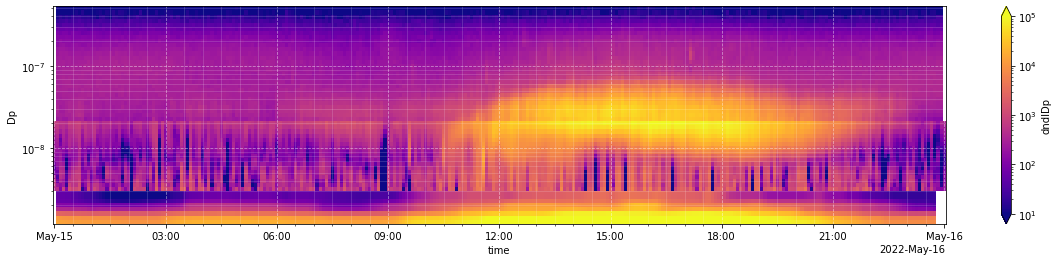

In [41]:
dc1.bnn.plot_psd(vmax=1e5)
f = plt.gcf()
f.set_figwidth(20)

In [43]:
dc1_ = dc1
for i in range(5):
    dc1_ = dc1_.rolling({"secs": 3}, center=True, min_periods=1).mean()

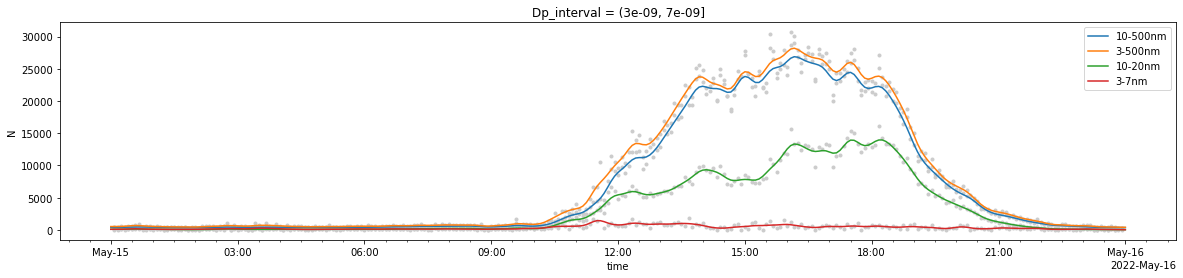

In [46]:
dc1.bnn.get_exact_N(10e-9, 500e-9).bnn.set_time().plot(
    marker=".", lw=0, c=".8"
)
dc1.bnn.get_exact_N(3e-9, 500e-9).bnn.set_time().plot(
    marker=".", lw=0, c=".8"
)
dc1.bnn.get_exact_N(10e-9, 20e-9).bnn.set_time().plot(
    marker=".", lw=0, c=".8"
)
dc1.bnn.get_exact_N(3e-9, 7e-9).bnn.set_time().plot(marker=".", lw=0, c=".8")

dc1_.bnn.get_exact_N(10e-9, 500e-9).bnn.set_time().plot(label="10-500nm")
dc1_.bnn.get_exact_N(3e-9, 500e-9).bnn.set_time().plot(label="3-500nm")
dc1_.bnn.get_exact_N(10e-9, 20e-9).bnn.set_time().plot(label="10-20nm")
dc1_.bnn.get_exact_N(3e-9, 7e-9).bnn.set_time().plot(label="3-7nm")


bfu.format_ticks(plt.gca())
plt.gca().legend()
plt.gcf().set_figwidth(20)
# plt.gca().set_xlim('2022-05-15 09','2022-05-15 12')

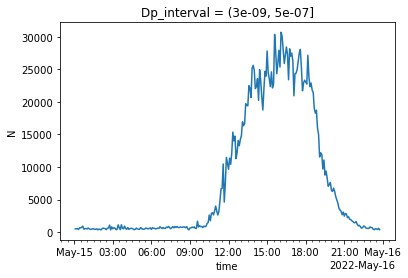

In [48]:
dc1.bnn.get_exact_N(3e-9, 500e-9).bnn.set_time().plot()
bfu.format_ticks(plt.gca())

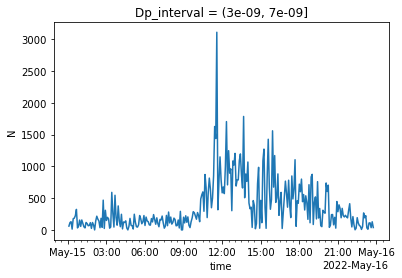

In [50]:
dc1.bnn.get_exact_N(3e-9, 7e-9).bnn.set_time().plot()
bfu.format_ticks(plt.gca())

In [51]:
_l = np.round(np.geomspace(3, 500, 8)).astype(int)

In [52]:
_tups = [np.array([_l[i_], _l[i_ + 1]]) for i_ in range(len(_l) - 1)]

In [53]:
dc1.bnn.set_Dp()["Dp"]

<xarray.DataArray 'Dp' (Dp: 53)>
array([1.258925e-09, 1.412538e-09, 1.584893e-09, 1.778279e-09, 1.995262e-09,
       2.238721e-09, 2.511886e-09, 2.818383e-09, 3.162278e-09, 3.548134e-09,
       3.981072e-09, 4.466836e-09, 5.011872e-09, 5.623413e-09, 6.309573e-09,
       7.079458e-09, 7.943282e-09, 8.912509e-09, 1.000000e-08, 1.122018e-08,
       1.258925e-08, 1.412538e-08, 1.584893e-08, 1.778279e-08, 1.995262e-08,
       2.238721e-08, 2.511886e-08, 2.818383e-08, 3.162278e-08, 3.548134e-08,
       3.981072e-08, 4.466836e-08, 5.011872e-08, 5.623413e-08, 6.309573e-08,
       7.079458e-08, 7.943282e-08, 8.912509e-08, 1.000000e-07, 1.122018e-07,
       1.258925e-07, 1.412538e-07, 1.584893e-07, 1.778279e-07, 1.995262e-07,
       2.238721e-07, 2.511886e-07, 2.818383e-07, 3.162278e-07, 3.548134e-07,
       3.981072e-07, 4.466836e-07, 5.011872e-07])
Coordinates:
    lDp      (Dp) float64 -8.9 -8.85 -8.8 -8.75 -8.7 ... -6.45 -6.4 -6.35 -6.3
  * Dp       (Dp) float64 1.259e-09 1.413e-09 1.585e-09 ... 4.467e-07 5.012e-07

In [55]:
cm = plt.get_cmap("plasma")

In [56]:
from matplotlib.lines import Line2D

print(Line2D.markers.keys())

dict_keys(['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''])


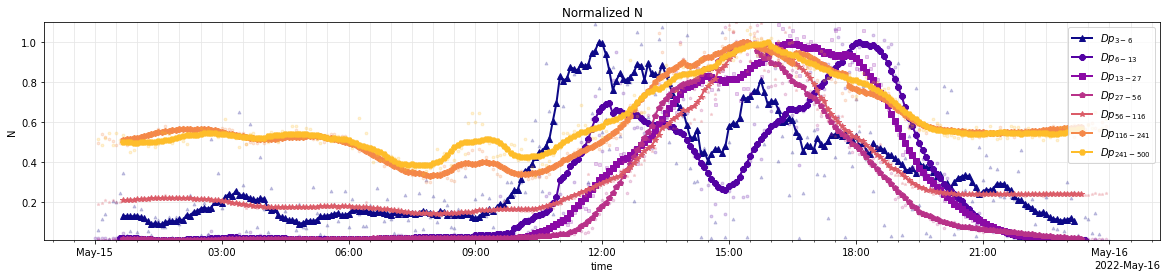

In [58]:
m_ = ["^", "8", "s", "p", "*", "h", "H"]
for i, t_ in enumerate(_tups):
    _d = dc1.bnn.get_exact_N(*(t_ * 1e-9))
    _d1 = _d.rolling({"secs": 15}, center=True).mean()
    (_d / _d1.max()).bnn.set_time().plot(
        x="time", label="", c=cm(i / len(_tups)), lw=0, marker=m_[i], alpha=0.2, ms=3
    )

    (_d1 / _d1.max()).bnn.set_time().plot(
        x="time",
        label=f"$Dp_{{{t_[0]}-{t_[1]}}}$",
        c=cm(i / len(_tups)),
        lw=2,
        marker=m_[i],
    )

ax = plt.gca()
ax.legend()
bfu.format_ticks(ax)
f = plt.gcf()
f.set_figwidth(20)
# ax.set_yscale('log')

ax.set_ylim(1e-2, 1.1)
ax.grid(which="both", c=".9")
ax.set_title("Normalized N");

In [59]:
d1 = 7e-9
d2 = 20e-9

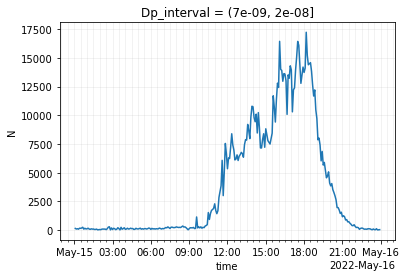

In [60]:
dc1.bnn.get_exact_N(d1, d2).bnn.set_time().plot()
bfu.format_ticks(plt.gca())
ax = plt.gca()
ax.grid(which="both", alpha=0.2)

In [61]:
# dc in m3
dcM = dc1 * 1e6

In [62]:
T = 270
P = 100000

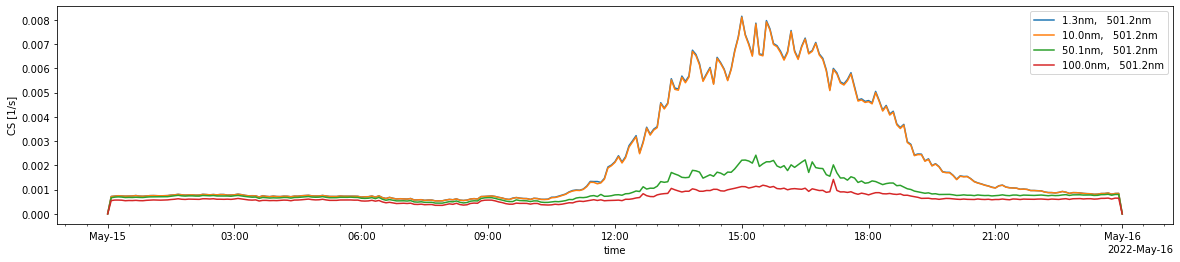

In [63]:
def _plt1(d1_, d2_):

    dN, d1, d2 = dcM.bnn.get_dN(d1_, d2_)
    dN_m3 = dN

    cs_ = cs.calc_CS(dN_m3=dN_m3, P=P, T=T)
    cs_.bnn.set_time().plot(label=f"{d1*1e9:.1f}nm,   {d2*1e9:.1f}nm")
    ax = plt.gca()
    ax.legend()
    bfu.format_ticks(ax)
    f = plt.gcf()
    f.set_figwidth(20)


_plt1(1e-9, 1000e-9)
_plt1(10e-9, 1000e-9)
_plt1(50e-9, 1000e-9)
_plt1(100e-9, 1000e-9)

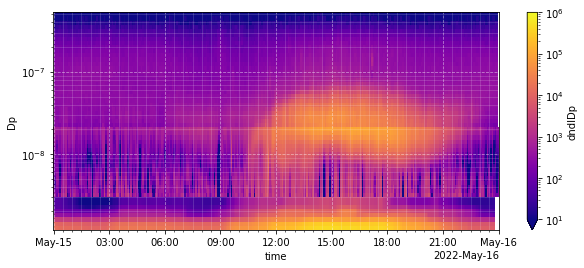

In [71]:
(dcM*1e-6).bnn.plot_psd()

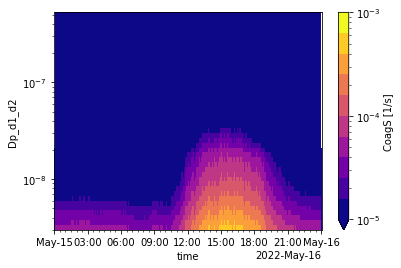

In [68]:
def _plt_coag_snk():
    dN_m3, d1, d2 = dcM.bnn.set_Dp().bnn.get_dN(0, 1)
    dens1 = dens2 = 1_200
    alpha = 1
    d1 = 3e-9
    d2 = 1_000e-9

    _r = cs.calc_coag_snk_xr(
        dN_tot_m3=dN_m3, d1=d1, d2=d2, P=P, T=T, alpha=alpha, dens1=dens1, dens2=dens2
    )

    __r = _r["CoagS"].bnn.set_time()
    _cm = plt.get_cmap('plasma',10)
    __r.bnn.set_time().plot(
        norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-3), yscale="log", robust=True,
        cmap = _cm 
    )
    bfu.format_ticks(plt.gca())


_plt_coag_snk()

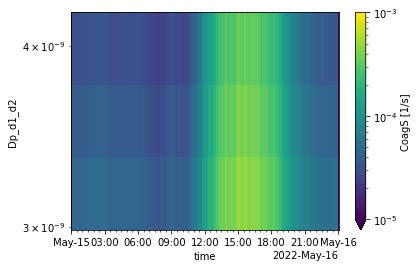

In [111]:
dN_m3,d1,d2 = dcM.bnn.set_Dp()['dndlDp'].bnn.get_dN(0,1)
dens1 = dens2 = 1200 
alpha = 1 
d1 = 3e-9
d2 = 4e-9

_r = cs.calc_coag_snk_xr(dN_tot_m3 = dN_m3 , d1 = d1, d2 = d2 , P = P, T = T , alpha = alpha, dens1 = dens1, dens2 = dens2)

__r = _r['CoagS'].bnn.set_time()
__r.bnn.set_time().plot(norm=mpl.colors.LogNorm(vmin=1e-5,vmax = 1e-3),yscale='log', robust = True)
bfu.format_ticks(plt.gca())

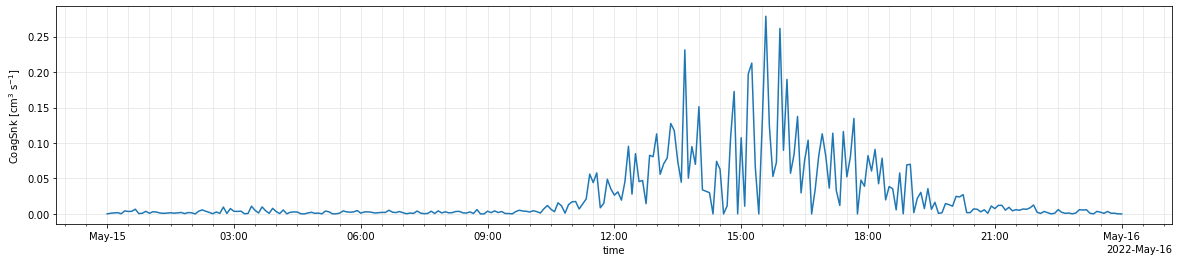

In [464]:
r1 = _r["CoagSnk"] * 1e-6
r1.bnn.u(r"cm$^3$ s$^{-1}$")
r1.bnn.set_time().plot()
ax = plt.gca()
ax.grid(which="both", color=".9")
plt.gcf().set_figwidth(20)
bfu.format_ticks(ax)

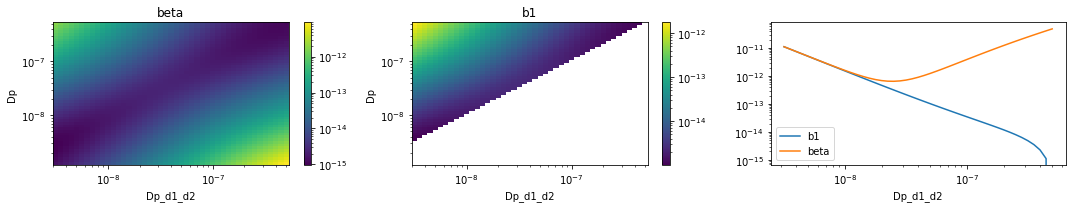

In [88]:
def method_name():
    f, axs = plt.subplot_mosaic("abc", figsize=(3 * 5, 3))

    dN_m3, d1, d2 = dcM.bnn.set_Dp()["dndlDp"].bnn.get_dN(0, 1)
    dens1 = dens2 = 1200
    alpha = 1
    d1 = 3e-9
    d2 = 1000e-9

    _Dp12 = dN_m3["Dp"].loc[{"Dp": slice(d1, d2)}]
    Dp12 = xr.DataArray(
        _Dp12.values, dims="Dp_d1_d2", coords={"Dp_d1_d2": _Dp12.values}
    )

    Dp_, Dp12_ = xr.broadcast(dN_m3["Dp"], Dp12)

    def _calc_beta(Dp12_, Dp_, alpha, axs, dens1, dens2):
        beta = cs.calc_coag_coef_fuchs(
            d1=Dp12_, dens1=dens1, d2=Dp_, dens2=dens2, T=T, P=P, alpha=alpha
        )
        b1 = beta.where(beta["Dp"] > beta["Dp_d1_d2"])
        beta.plot(yscale="log", xscale="log", norm=mpl.colors.LogNorm(), ax=axs["a"])
        b1.plot(yscale="log", xscale="log", norm=mpl.colors.LogNorm(), ax=axs["b"])
        ax = axs["c"]
        b1.sum("Dp").plot(label="b1", ax=ax)
        beta.sum("Dp").plot(label="beta", ax=ax)
        ax = plt.gca()
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.legend()
        axs["a"].set_title("beta")
        axs["b"].set_title("b1")
        f.tight_layout()

    _calc_beta(Dp12_, Dp_, alpha, axs, dens1, dens2)


method_name()

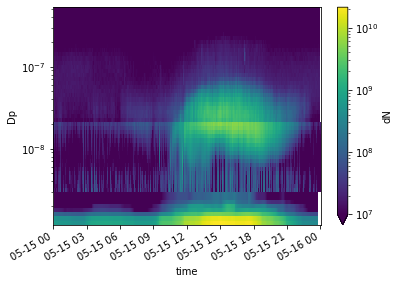

In [89]:
(dN_m3 + 0.00001).bnn.set_time().plot(norm=mpl.colors.LogNorm(vmin=1e7), yscale="log")

In [81]:
p = '/Users/aliaga/Documents/Work_DA/Work_inar/paper-2/small_data/v2_tratead_psd_data_smps_nais_chc_alto/v2_tratead_psd_data_smps_nais_chc_alto.nc'

In [82]:
ds = xr.open_dataarray(p)

In [84]:
ds.id

<xarray.DataArray 'id' (id: 8)>
array(['ion_neg', 'ion_pos', 'nais_ion_neg_neutral_smps',
       'nais_ion_neutral_smps', 'nais_neutral_smps', 'neutral_neg',
       'neutral_pos', 'smps'], dtype=object)
Coordinates:
  * id       (id) object 'ion_neg' 'ion_pos' ... 'neutral_pos' 'smps'

In [113]:
d = '2018-05-17'
i = 'nais_ion_neg_neutral_smps'

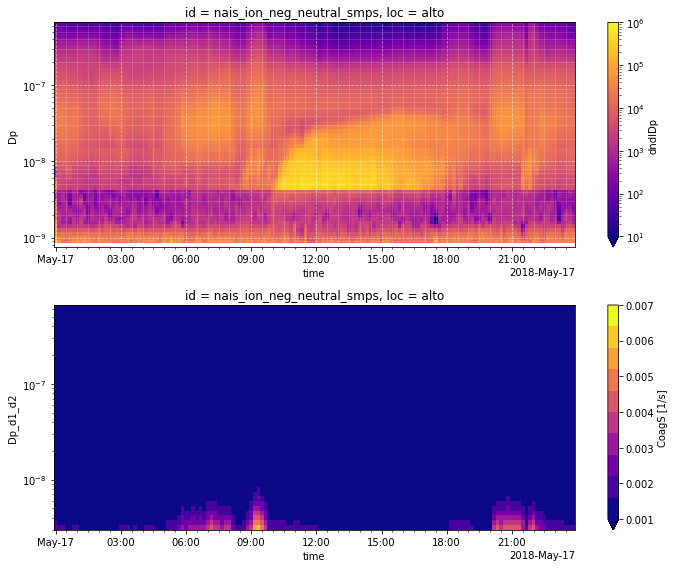

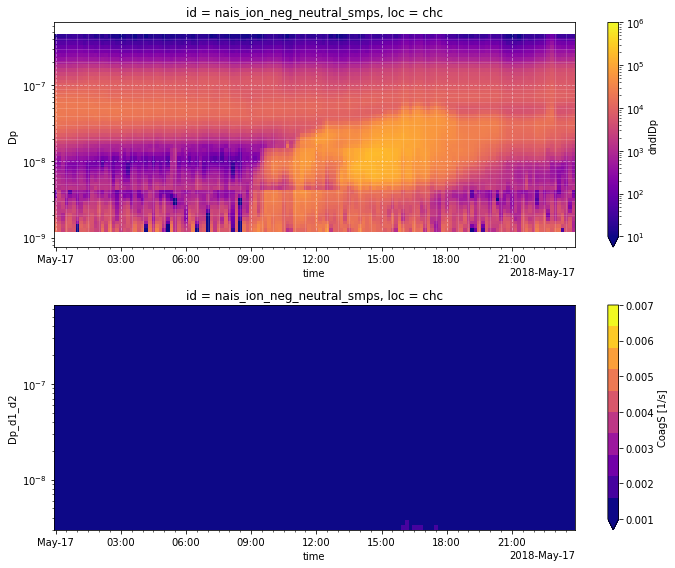

In [121]:
def _plt_coag_snk(loc):
    
    ds1 = ds.loc[{'id':i,'loc':loc,'time':d}]
    
    f,(ax1,ax2) = plt.subplots(2,figsize=(4,8))
    ds1.bnn.plot_psd(ax=ax1)
    dN_m3, d1, d2 = (ds1*1e6).bnn.get_dN(0,1)
    dens1 = dens2 = 1_200
    alpha = 1
    d1 = 3e-9
    d2 = 1_000e-9

    _r = cs.calc_coag_snk_xr(
        dN_tot_m3=dN_m3, d1=d1, d2=d2, P=530, T=270, alpha=alpha, dens1=dens1, dens2=dens2
    )

    __r = _r["CoagS"].bnn.set_time()
    _cm = plt.get_cmap('plasma',10)
    __r.bnn.set_time().plot(ax=ax2,
        norm=mpl.colors.Normalize(vmin=.001, vmax=.007), yscale="log", robust=True,
        cmap = _cm 
    )
    bfu.format_ticks(plt.gca())
    f.tight_layout()


_plt_coag_snk('alto')
_plt_coag_snk('chc')